In [1]:
from IPython.display import Latex

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

from numba import njit, prange, float64
import numpy as np

from wf import sigma, epsilon, eta, V_lj, build_fn

from scipy.linalg import eig
from scipy.optimize import curve_fit

np.random.seed(0)

## Parameters of the system

In [2]:
N = 64

rho0 = 21.86e-3 * sigma**3
L = (N / (rho0))**(1/3)

fn, rgrid = build_fn(L)

Latex(f'$L = {L:.3f}\\ \\sigma$')

<IPython.core.display.Latex object>

In [3]:
from itertools import product

# intial configuration
conf = np.zeros((N, 3))

ind = 0 # uniformly distributed particles
for i, j, k in product(range(4), repeat=3):
    conf[ind] = L/4 * np.array([i, j, k])
    ind += 1

# Variational wave function

In [4]:
# create function for every fn and derivatives

fn_prime  = np.apply_along_axis(np.gradient, 1, fn, rgrid)
fn_prime[:, -11:] = 0.

fn_second = np.apply_along_axis(np.gradient, 1, fn_prime, rgrid)

f0 = njit(lambda r: np.interp(r, rgrid, fn[0]), fastmath=True)
f0_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[0]), fastmath=True)
f0_second = njit(lambda r: np.interp(r, rgrid, fn_second[0]), fastmath=True)

f1 = njit(lambda r: np.interp(r, rgrid, fn[1]), fastmath=True)
f1_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[1]), fastmath=True)
f1_second = njit(lambda r: np.interp(r, rgrid, fn_second[1]), fastmath=True)

f2 = njit(lambda r: np.interp(r, rgrid, fn[2]), fastmath=True)
f2_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[2]), fastmath=True)
f2_second = njit(lambda r: np.interp(r, rgrid, fn_second[2]), fastmath=True)

f3 = njit(lambda r: np.interp(r, rgrid, fn[3]), fastmath=True)
f3_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[3]), fastmath=True)
f3_second = njit(lambda r: np.interp(r, rgrid, fn_second[3]), fastmath=True)

f4 = njit(lambda r: np.interp(r, rgrid, fn[4]), fastmath=True)
f4_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[4]), fastmath=True)
f4_second = njit(lambda r: np.interp(r, rgrid, fn_second[4]), fastmath=True)

In [5]:
@njit(fastmath=True) # 2-body correlation factor
def f(r_ij, cn):
    f_ij  = cn[0]*f0(r_ij)
    f_ij += cn[1]*f1(r_ij)
    f_ij += cn[2]*f2(r_ij)
    f_ij += cn[3]*f3(r_ij)
    f_ij += cn[4]*f4(r_ij)
    return f_ij


@njit(fastmath=True) # radial derivative of f
def f_prime(r_ij, cn):
    f_ij_prime  = cn[0] * f0_prime(r_ij)
    f_ij_prime += cn[1] * f1_prime(r_ij)
    f_ij_prime += cn[2] * f2_prime(r_ij)
    f_ij_prime += cn[3] * f3_prime(r_ij)
    f_ij_prime += cn[4] * f4_prime(r_ij)
    return f_ij_prime


@njit(fastmath=True) # second radial derivative of f
def f_second(r_ij, cn):
    f_ij_second  = cn[0] * f0_second(r_ij)
    f_ij_second += cn[1] * f1_second(r_ij)
    f_ij_second += cn[2] * f2_second(r_ij)
    f_ij_second += cn[3] * f3_second(r_ij)
    f_ij_second += cn[4] * f3_second(r_ij)
    return f_ij_second


@njit(fastmath=True)
def psi(conf, cn, L):
    # pairwise vector distance matrix
    R_ij = conf - np.expand_dims(conf, axis=1)
    R_ij = R_ij - L * np.rint(R_ij / L)

    # pairwise distance matrix
    r_ij = np.sqrt(np.sum(R_ij**2, axis=2))
    
    r_ij = np.where((r_ij > 0) & (r_ij < L/2), r_ij, L/2)
    
    return np.sqrt(np.prod(f(r_ij, cn)))

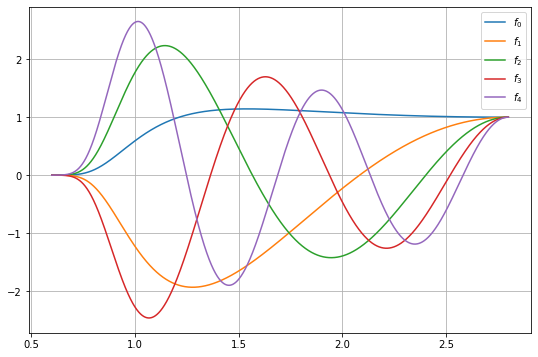

In [6]:
for i in range(5):
    plt.plot(rgrid, eval(f'f{i}(rgrid)'), label=f'$f_{i}$')

plt.legend()
plt.grid()

[ 0.91040499  0.10716231 -0.01999047  0.00926365 -0.00684047]


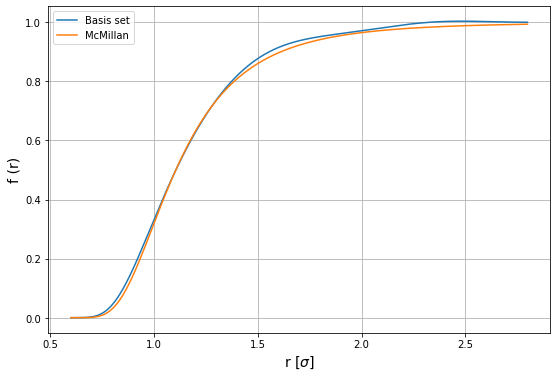

In [7]:
# starting values of cn: fit f on McMillan function
f_fit = lambda r, c0, c1, c2, c3, c4: c0*f0(r) + c1*f1(r) + c2*f2(r) + c3*f3(r) + c4*f4(r)
McMillan = np.exp(- 0.5 * (1.18**5 / rgrid**5))
cn, pcov = curve_fit(f_fit, rgrid, McMillan)

cn = cn / np.sum(cn)

print(cn)

plt.plot(rgrid, f(rgrid, cn),  label='Basis set')
plt.plot(rgrid, np.exp(- 0.5 * (1.18**5 / rgrid**5)), label='McMillan')
plt.xlabel('r [$\\sigma$]', fontsize=14)
plt.ylabel('f (r)', fontsize=14)
plt.legend()
plt.grid()

In [8]:
@njit(fastmath=True) # sample MC configurations on psi(*, cn)
def sample(conf, cn, L):
    # number of particles
    N = conf.shape[0]
    # equilibration steps
    eq_steps = 10000
    # MC calculation steps
    n_samples = 50000
    
    # delta parameter starting value
    delta = L / 10
    
    # forward steps in Markov chain
    fw_steps = 0

    # EQUILIBRATION: bring system to equilibrium
    P_i = psi(conf, cn, L)**2
    for i in range(eq_steps):
        
        # build Markov chain step proposal
        proposal = conf + delta * (np.random.rand(N, 3) - 0.5)
        # apply pbc
        proposal -= L * np.floor(proposal / L)
        
        # probability of proposal configuration
        P_p = psi(proposal, cn, L)**2
        # Markov chain step decision
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
            fw_steps += 1

        # update delta value every 500 steps based on % of forward steps
        if ((i+1) % 500 == 0):
            if (fw_steps > 300) or (fw_steps < 200):
                delta = delta * (0.5 + fw_steps/500)
            # reset forward steps counter
            fw_steps = 0
    
    Ecorr = np.zeros(10000)
    for i in range(10000):
        Ecorr[i] = localEnergy(conf, cn, L)
        
        # build Markov chain step proposal
        proposal = conf + delta * (np.random.rand(N, 3) - 0.5)
        # apply pbc
        proposal -= L * np.floor(proposal / L)
        
        # probability of proposal configuration
        P_p = psi(proposal, cn, L)**2
        # Markov chain step decision
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
        
    
    tau_bar = int(autocorrelation(Ecorr).sum())
    
    samples = np.zeros((n_samples, N, 3))
    samples[0] = np.copy(conf)

    P_i = psi(conf, cn, L)**2
    
    # SAMPLING
    for i in range(n_samples*tau_bar):
        # build Markov chain step proposal
        proposal = conf + delta * (np.random.rand(N, 3) - 0.5)
        # apply pbc
        proposal -= L * np.floor(proposal / L)
        
        # probability of proposal configuration
        P_p = psi(proposal, cn, L)**2
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
            
        if i % tau_bar == 0:
            samples[i // tau_bar] = np.copy(conf)

    return samples

In [9]:
@njit(fastmath=True) # compute autocorrelation coefficient
def autocorrelation(E):
    tau_max = 300
    c_tau = np.zeros(tau_max)
            
    # iterate over tau
    for tau in range(tau_max):
        for i in range(len(E) - tau):
            c_tau[tau] += E[i] * E[i + tau] / (len(E) - tau)

    # compute coefficent for every tau
    c_tau = (c_tau - np.mean(E)**2) / np.var(E)
    
    return c_tau


@njit(fastmath=True)
def localEnergy(conf, cn, L):
    # pairwise vetor distance matrix
    R_kl = conf - np.expand_dims(conf, axis=1)
    R_kl = R_kl - L * np.rint(R_kl / L)

    # pairwise distance matrix
    r_kl = np.sqrt(np.sum(R_kl**2, axis=2))
    # avoid r_ii and cutoff at L/2
    r_kl = np.where((r_kl < L/2) & (r_kl > 0), r_kl, L/2)

    f_kl = f(r_kl, cn)
    
    u_prime  = - f_prime(r_kl, cn) / f_kl
    u_second = u_prime**2 - f_second(r_kl, cn) / f_kl

    grad = np.sum(u_prime  / r_kl * R_kl.T, axis=1)

    E  = eta / 2 * np.sum(u_second + 2 / r_kl * u_prime) # Laplacian
    E -= eta / 2 * np.sum(grad**2) # square of the gradient

    # cutoff on potential
    r_kl = np.where(r_kl < L/2, r_kl, -1.)
    E += np.sum(V_lj(r_kl)) / 2
    
    return E

In [10]:
@njit(fastmath=True)
def energy(samples, cn, L):
    # number of particles
    N = samples.shape[1]
    # number of uncorrelated samples
    n_samples = samples.shape[0]
    
    # psi_j / psi_0
    psi_j0 = np.zeros((5, n_samples))
    # local energy
    E_l = np.zeros(n_samples)
    # E_lj
    E_lj = np.zeros((5, n_samples))
    
    for i in range(n_samples):
        # pairwise vetor distance matrix
        R_kl = samples[i] - np.expand_dims(samples[i], axis=1)
        R_kl = R_kl - L * np.rint(R_kl / L)

        # pairwise distance matrix
        r_kl = np.sqrt(np.sum(R_kl**2, axis=2))
        # avoid r_ii and cutoff at L/2
        r_kl = np.where((r_kl < L/2) & (r_kl > 0), r_kl, L/2)
        
        f_kl = f(r_kl, cn)

        u0 = - f0(r_kl) / f_kl
        u1 = - f1(r_kl) / f_kl
        u2 = - f2(r_kl) / f_kl
        u3 = - f3(r_kl) / f_kl
        u4 = - f4(r_kl) / f_kl
        
        u_prime  = - f_prime(r_kl, cn) / f_kl
        
        u0_prime = - f0_prime(r_kl) / f_kl + u_prime * u0
        u1_prime = - f1_prime(r_kl) / f_kl + u_prime * u1
        u2_prime = - f2_prime(r_kl) / f_kl + u_prime * u2
        u3_prime = - f3_prime(r_kl) / f_kl + u_prime * u3
        u4_prime = - f4_prime(r_kl) / f_kl + u_prime * u4
        
        u_second = u_prime**2 - f_second(r_kl, cn) / f_kl
        
        u0_second  = - f0_second(r_kl) / f_kl + u0 * (u_second - u_prime**2)
        u0_second += 2 * u_prime * u0_prime
        
        u1_second  = - f1_second(r_kl) / f_kl + u1 * (u_second - u_prime**2)
        u1_second += 2 * u_prime * u1_prime
        
        u2_second  = - f2_second(r_kl) / f_kl + u2 * (u_second - u_prime**2)
        u2_second += 2 * u_prime * u2_prime
        
        u3_second  = - f3_second(r_kl) / f_kl + u3 * (u_second - u_prime**2)
        u3_second += 2 * u_prime * u3_prime
        
        u4_second  = - f4_second(r_kl) / f_kl + u4 * (u_second - u_prime**2)
        u4_second += 2 * u_prime * u4_prime
        
        grad  = np.sum(u_prime  / r_kl * R_kl.T, axis=1)
        grad0 = np.sum(u0_prime / r_kl * R_kl.T, axis=1)
        grad1 = np.sum(u1_prime / r_kl * R_kl.T, axis=1)
        grad2 = np.sum(u2_prime / r_kl * R_kl.T, axis=1)
        grad3 = np.sum(u3_prime / r_kl * R_kl.T, axis=1)
        grad4 = np.sum(u4_prime / r_kl * R_kl.T, axis=1)
        
        psi_j0[0, i] = np.sum(- u0) / 2
        psi_j0[1, i] = np.sum(- u1) / 2
        psi_j0[2, i] = np.sum(- u2) / 2
        psi_j0[3, i] = np.sum(- u3) / 2
        psi_j0[4, i] = np.sum(- u4) / 2
        
        psi_j0[:, i] -= len(np.where(r_kl == L/2)[0]) / 2
        
        E_lj[0, i] = np.sum(u0_second + 2/r_kl * u0_prime) # Laplacian
        E_lj[0, i] -= 2 * np.sum(grad * grad0)
        
        E_lj[1, i] = np.sum(u1_second + 2/r_kl * u1_prime) # Laplacian
        E_lj[1, i] -= 2 * np.sum(grad * grad1)
        
        E_lj[2, i] = np.sum(u2_second + 2/r_kl * u2_prime) # Laplacian
        E_lj[2, i] -= 2 * np.sum(grad * grad2)
        
        E_lj[3, i] = np.sum(u3_second + 2/r_kl * u3_prime) # Laplacian
        E_lj[3, i] -= 2 * np.sum(grad * grad3)
        
        E_lj[4, i] = np.sum(u4_second + 2/r_kl * u4_prime) # Laplacian
        E_lj[4, i] -= 2 * np.sum(grad * grad4)
        
        E_l[i]  = eta / 2 * np.sum(u_second + 2/r_kl * u_prime) # Laplacian
        E_l[i] -= eta / 2 * np.sum(grad**2) # square of the gradient
        
        # cutoff on potential
        r_kl = np.where(r_kl < L/2, r_kl, -1.)
        E_l[i] += np.sum(V_lj(r_kl)) / 2
    
    E_lj = eta / 2 * E_lj
    return E_l, E_lj, psi_j0

In [11]:
def build_HS(E_l, E_lj, psi_j0):
    S = np.zeros((6, 6))
    S[0, 0] = 1.

    for i in range(5):
        for j in range(i, 5):
            S[i+1, j+1]  = np.mean(psi_j0[i] * psi_j0[j]) 
            S[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(psi_j0[j])
            S[j+1, i+1]  = float(S[i+1, j+1])


    H = np.zeros((6, 6))
    H[0, 0] = np.mean(E_l)

    for i in range(5):
        H[i+1, 0] = np.mean(E_l * psi_j0[i]) - H[0, 0] * np.mean(psi_j0[i]) + np.mean(E_lj[i])
        H[0, i+1] = np.mean(E_l * psi_j0[i]) - H[0, 0] * np.mean(psi_j0[i])

    for i in range(5):
        for j in range(5):
            H[i+1, j+1]  = np.mean(psi_j0[i] * psi_j0[j] * E_l)
            H[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(psi_j0[j] * E_l)
            H[i+1, j+1] -= np.mean(psi_j0[i] * E_l) * np.mean(psi_j0[j])
            H[i+1, j+1] += np.mean(psi_j0[i]) * np.mean(psi_j0[j]) * H[0, 0]
            H[i+1, j+1] += np.mean(psi_j0[i] * E_lj[j]) 
            H[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(E_lj[j])
            
    return H, S


# long-range correction
def LRC(N, L):
    rho = N / L**3
    rc = L / 2
    return N * (8 / 3 * np.pi * rho * (1 / (3*rc**9) - 1 / rc**3))

In [12]:
import datetime as dt

In [ ]:
%%time

El = np.zeros(10)
e  = np.zeros(10)
p  = np.zeros((10, 5))

p[0] = np.copy(cn)

for i in range(10):
    samples = sample(conf, p[i], L)
    E_l, E_lj, psi_j0 = energy(samples, p[i], L)
    
    H, S = build_HS(E_l + LRC(N, L), E_lj, psi_j0)
    E, P = eig(H, S)
    
    E = np.real(E)
    P = np.real(P)
    
    e[i] = np.min(E) / N * epsilon
    
    delta_p = P[1:, np.argmin(E)] / P[0, np.argmin(E)]
    p[i+1] = p[i] + delta_p
    p[i+1] = p[i+1] / np.sum(p[i+1])
    
    El[i] = np.mean(E_l) / N * epsilon
    sigmaE = np.std(E) / np.sqrt(50000) / N * epsilon
    
    print(dt.datetime.now().time())
    display(Latex(f'Step {i}: $E_l = {El[i]:.4f} \pm {sigmaE:.4f} K$, $\epsilon = {e[i]:.4f}'))
    
El += LRC(N, L) / N * epsilon

15:09:41.959911


# NEW APPROACH